# Georgia Tech ISYE6420 Course Project

**Fall 2023  
Spencer Vore**

In [1]:
import pymc as pm
import pandas as pd
from pandas.api.types import is_numeric_dtype

import arviz as az
from collections.abc import Sequence
from typing import Optional

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Define adjustable Constants / Settings  
Use this to adjust script settings / MCMC run. Sorry, didn't add it to a .env file or something fancier. Works for purpose of demo / tinkering.

In [2]:
n_all = 500 # Size of data we want for MCMC. Randomly sample this many points from full dataset. Includes train and test sample size.
n_seed = 42 # Random seed for down sampling n datapoints from full dataset

n_test = 50 # Size of test set we want to saomple from n_all.
split_seed = 43 # Random seed used for train / test split

path_to_datafile = "abalone/abalone.data"

### Prepare Dataset

**Load Dataset**

In [3]:
data = pd.read_csv(path_to_datafile, header=None)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
data.shape

(4177, 9)

**Downsample dataset**  
This will help the MCMC algorithm run faster... can adjust upward for better prediction accuracy, or downward for faster computation. Take random sample of data.

In [6]:
# Uncomment this line to use full datasize
# n = data.shape[0]

In [7]:
n = 500
assert n <= data.shape[0] # Can't chose more samples than size of data
data = data.sample(n, random_state=n_seed)

**Split data into training and test sets**

In [8]:
data.shape

(500, 9)

In [9]:
assert n_test < n_all # Test size should be smaller than full size
train_data, test_data = train_test_split(data, test_size=n_test, random_state=split_seed)

In [10]:
train_data.shape

(450, 9)

In [11]:
test_data.shape

(50, 9)

**Standardize train dataset**  
Not sure if this is nessecary, but doesn't hurt and could help.

In [12]:
class DataPrep:
    '''
    Standardize the data. By writing this as an object, we can save the statistics calculated for the standardization
    so we can use them later to predict new datapoints in our model.
    '''
    def __init__(self):
        self.means = dict()
        self.stdevs = dict()
        
    def prep(self, X_df: pd.DataFrame, X_df_all: Optional[pd.DataFrame] = None, use_prev_standardization=False) -> pd.DataFrame:
        """
        This takes a dataset, and prepares it. Numerical columns are standardized. Categorical columns 
        are one hot encoded so we can fit a numerical regression with a coefficient for each category.
        
        From TA's example github for numerical standardization
        Standardize input variables by 2 std dev.

        For standardization, see:
        https://stat.columbia.edu/~gelman/research/published/standardizing7.pdf
        https://areding.github.io/6420-pymc/unit7/Unit7-arrhythmia.html
        
        INPUTS:
        X_df - The train or test dataset you want to standardize and one hot encode
        X_df_all - The full dataset you sampled X_df from. Used to check that all categorical values in X_df_all are also in X_df. Otherwise,
            you will get an output dataset that doesn't fully one hot encode the full dataset and your dimensions will be off. If this fails,
            you will need to add more logic to this function to handle the edge case. Right now, it just throws and exception.
        use_prev_standardization - Set this to true is X_df is a test set. This will use previously saved means and stdevs from training set 
            (saved in the object) to standardize the test dataset in the same way. If fasle, will recalculate the means and stdev from X_df.
        
        RETURNS:
        Standardized and one hot encoded dataframe based on X_df input
        """
        
        X_standardized = pd.DataFrame()
            
        for colname in X_df.columns:
            col = X_df[colname]
            if is_numeric_dtype(col):
                if not use_prev_standardization:
                    self.means[colname] = col.mean()
                    self.stdevs[colname] = col.std()
                X_standardized[colname] = (col - self.means[colname]) / (2 * self.stdevs[colname])
            else:
                X_onehot = pd.get_dummies(X_df[colname], prefix=colname, dtype=int)
                
                # Make sure all categorical values are in subsample. If this breaks,
                # add logic to handle this edge case, such as inserting missing column where 
                # everything is False
                X_onehot_all = pd.get_dummies(X_df_all[colname], prefix=colname, dtype=int)
                assert set(X_onehot.columns) == set(X_onehot_all.columns)
                    
                if X_standardized.empty:
                    X_standardized = X_onehot
                else:
                    X_standardized = X_standardized.join(X_onehot)
                if not use_prev_standardization:
                    onehot_colnames = X_onehot.columns
                    for o_colname in onehot_colnames:
                        self.means[o_colname] = None
                        self.stdevs[o_colname] = None

        return X_standardized


In [13]:
data_preper = DataPrep()
train_data_std = data_preper.prep(X_df = train_data, X_df_all = data)

In [14]:
train_data_std.head()

,0_F,0_I,0_M,1,2,3,4,5,6,7,8
3027,0,1,0,-0.076052,-0.115511,-0.033604,-0.303016,-0.298127,-0.259225,-0.089660,-0.278476
2509,0,1,0,-0.423394,-0.436831,-0.625319,-0.480531,-0.421290,-0.442054,-0.528727,-0.587513
3186,1,0,0,-0.198644,-0.214378,-0.362334,-0.337236,-0.271562,-0.240711,-0.388679,-0.587513
166,1,0,0,0.843384,0.848451,0.492365,1.403161,1.003537,1.261258,2.336564,1.575742
2855,1,0,0,0.557337,0.551847,0.229381,0.531626,0.421531,0.772945,0.576511,0.185078


In [15]:
train_data_std.shape

(450, 11)

In [16]:
data_preper.means

{'0_F': None,
 '0_I': None,
 '0_M': None,
 1: 0.5186111111111111,
 2: 0.4033666666666667,
 3: 0.13755555555555554,
 4: 0.81186,
 5: 0.34945,
 6: 0.17900555555555556,
 7: 0.23268777777777777,
 8: 9.802222222222222}

In [17]:
data_preper.stdevs

{'0_F': None,
 '0_I': None,
 '0_M': None,
 1: 0.12235765735250845,
 2: 0.10114516349285094,
 3: 0.03802505067832697,
 4: 0.4675656967761661,
 5: 0.2070427375106454,
 6: 0.10802485934416967,
 7: 0.1320983164834733,
 8: 3.2358645064622427}

In [18]:
X_train = train_data_std.drop(8, axis=1).to_numpy()
y_train = train_data_std[8].to_numpy()

In [19]:
X_train

array([[ 0.        ,  1.        ,  0.        , ..., -0.29812685,
        -0.25922531, -0.08965965],
       [ 0.        ,  1.        ,  0.        , ..., -0.42128983,
        -0.4420536 , -0.52872656],
       [ 1.        ,  0.        ,  0.        , ..., -0.27156229,
        -0.24071105, -0.38867936],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.73547617,
         0.91411572,  0.69006263],
       [ 0.        ,  0.        ,  1.        , ..., -0.20756584,
        -0.05093992,  0.04660249],
       [ 0.        ,  0.        ,  1.        , ...,  0.05928728,
        -0.04399707, -0.0101734 ]])

**Apply standardization to test dataset**

In [20]:
test_data_std = data_preper.prep(X_df = test_data, X_df_all = data, use_prev_standardization=True)

In [21]:
test_data_std.head()

,0_F,0_I,0_M,1,2,3,4,5,6,7,8
308,0,0,1,0.128267,0.032791,-0.165096,-0.054923,-0.238960,-0.071768,-0.142650,0.648633
1034,1,0,0,0.557337,0.279961,0.295127,0.729459,0.821207,0.703516,-0.189964,-0.123958
3637,0,1,0,-0.341667,-0.387397,-0.493827,-0.502453,-0.521511,-0.442054,-0.483306,-0.587513
4139,1,0,0,0.475609,0.452979,0.492365,0.453027,0.413079,0.599373,0.432679,0.030560
865,1,0,0,0.353018,0.354112,0.492365,0.609690,0.626803,0.247602,0.627609,0.030560


In [22]:
test_data_std.shape

(50, 11)

In [23]:
X_test = test_data_std.drop(8, axis=1).to_numpy()
y_test = test_data_std[8].to_numpy()

### Fit linear regression model

In [24]:
with pm.Model() as m_linear:
    # associate data with model (this makes prediction easier)
    X_data = pm.Data("X", X_train, mutable=True)
    y_data = pm.Data("y", y_train, mutable=True)

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=1000)
    coeffs = pm.Normal("coeffs", mu=0, sigma=1000, shape=X_data.shape[1])
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    mu = intercept + pm.math.dot(X_data, coeffs)

    # likelihood
    pm.Normal("age_of_tree", mu=mu, sigma=sigma, observed=y_data)

    # start sampling
    trace_linear = pm.sample(500, target_accept=0.95)
    pm.sample_posterior_predictive(trace_linear, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coeffs, tau]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 164 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [age_of_tree]


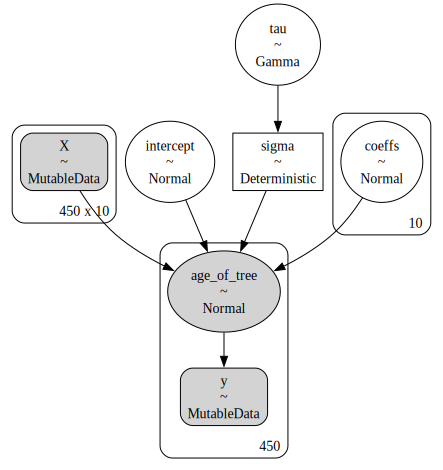

In [25]:
pm.model_to_graphviz(m_linear)

In [26]:
az.summary(trace_linear, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-99.939,27.441,-150.577,-42.486,7.729,5.597,13.0,39.0,1.24
coeffs[0],99.989,27.441,42.545,150.610,7.729,5.597,13.0,39.0,1.24
coeffs[1],99.824,27.442,42.383,150.385,7.729,5.597,13.0,39.0,1.24
coeffs[2],99.986,27.440,42.521,150.620,7.729,5.597,13.0,39.0,1.24
coeffs[3],-0.170,0.193,-0.534,0.216,0.021,0.015,83.0,138.0,1.05
coeffs[4],0.396,0.199,0.030,0.791,0.023,0.017,72.0,100.0,1.08
coeffs[5],0.314,0.083,0.179,0.507,0.015,0.012,38.0,24.0,1.09
coeffs[6],1.797,0.351,1.117,2.505,0.090,0.065,16.0,72.0,1.20
coeffs[7],-1.509,0.163,-1.830,-1.178,0.037,0.026,20.0,77.0,1.16
coeffs[8],-0.490,0.153,-0.794,-0.193,0.041,0.031,14.0,31.0,1.21


In [27]:
y_pred = trace_linear.posterior_predictive.stack(sample=("chain", "draw"))[
    "age_of_tree"
].values.T
az.r2_score(y_train, y_pred)

r2        0.540706
r2_std    0.019288
dtype: float64

Now predict test data, and compare MSE to actual.
See example in PyMC docs: https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html

In [28]:
pm.set_data({"X": X_test, "y": y_test}, model=m_linear)
ppc = pm.sample_posterior_predictive(trace_linear, model=m_linear, predictions=True)

Sampling: [age_of_tree, coeffs]


In [29]:
y_pred_test = ppc.predictions["age_of_tree"].mean(dim=["chain", "draw"]).values

In [30]:
y_pred_test

array([-111.97266428, -128.37107419,  -47.72177796, -106.44688811,
       -100.61820531, -113.58292948, -122.33762218,  -77.18273271,
        -60.8566979 ,  -36.11694572,  -58.85646943, -123.73088813,
       -119.42606783, -113.21845013, -108.30109301, -142.22415554,
        -56.88834042,  -75.23446826, -149.90889645, -124.44217234,
       -114.64797033,  -71.20831489,  -50.7145696 ,  -43.34567715,
       -114.31066463, -126.93097753,  -44.72826751, -113.50966266,
       -105.66418505,  -27.36639646, -101.74232398,  -78.54655118,
       -133.98980938,  -61.55892661,  -66.23128542, -130.58413745,
       -114.75174477,  -74.40997052,  -81.66115494,  -68.40805236,
       -150.36680691,  -48.60693632,  -66.74122074, -153.60399175,
        -73.87226145,  -86.57236442, -100.92177246, -135.61992495,
       -114.52441579,  -50.28596977])

In [31]:
y_pred_test.shape

(50,)

In [32]:
y_pred = trace_linear.posterior_predictive.stack(sample=("chain", "draw"))[
    "age_of_tree"
].values.T
az.r2_score(y_test, y_pred_test)

r2        0.49591
r2_std    0.00000
dtype: float64

**Calculate test set mean squared error. This is a better comparison than R2 once we start using non-linear models.**

In [33]:
round(mean_squared_error(y_test, y_pred_test), 2)

9940.84

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Tue Nov 28 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.15.0

pytensor: 2.17.3

arviz : 0.16.1
pymc  : 5.9.1
pandas: 2.1.3

